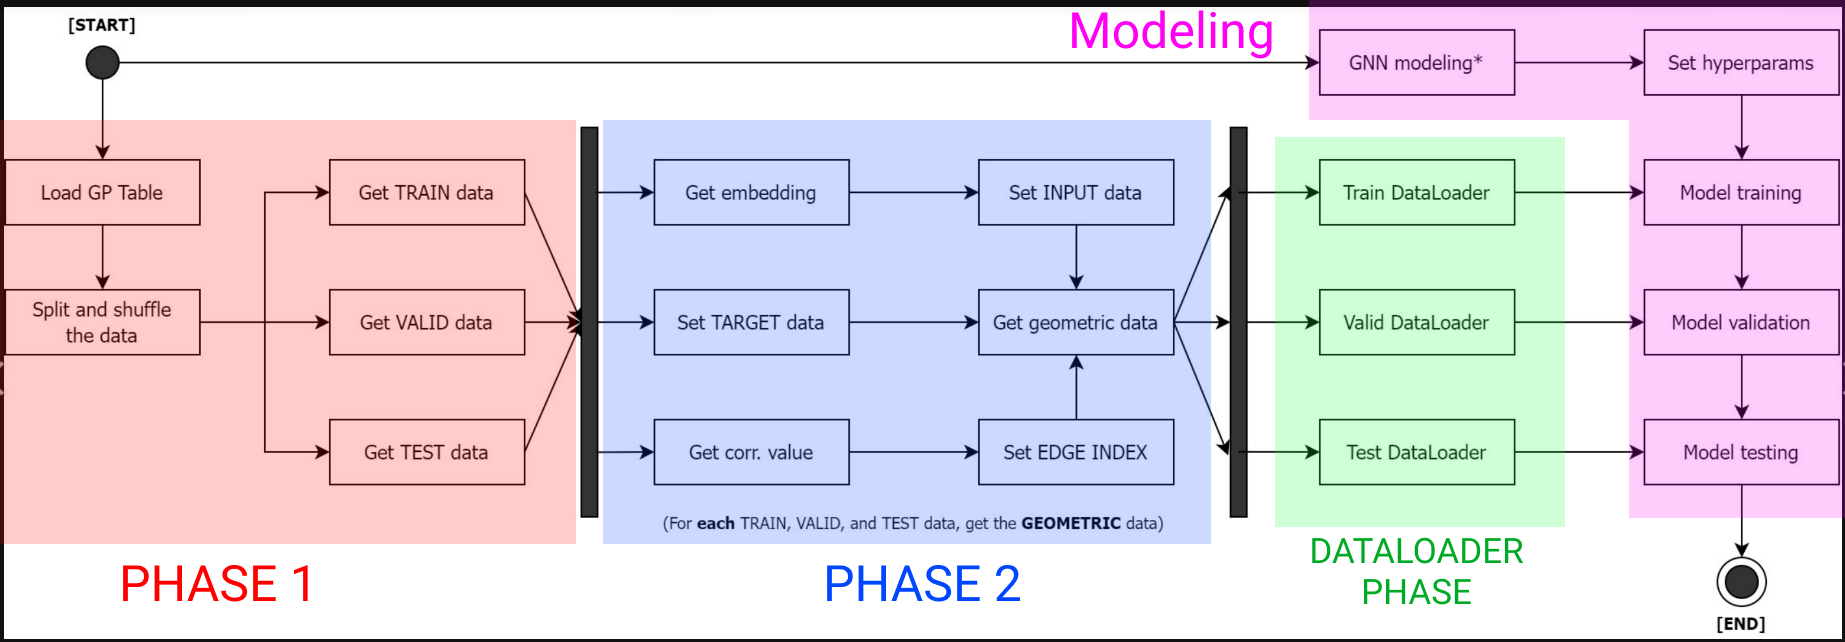

# PHASE 1

## Load dataset

In [ ]:
import pandas as pd
# big_dataset = pd.read_csv('dummy_data.csv')
big_dataset = pd.read_csv('gp_table.csv')

## Split and shuffle data

In [ ]:
y = big_dataset['rice_yield']
x = big_dataset['snps']

# variabel x malah berisikan array snps pada dataset namun dalam bentuk string, perlu dikembalikan menjadi list atau array
from ast import literal_eval
new_x = []
for i in x:
  new_x.append(literal_eval(i))

import numpy as np

# jadikan x dan y bentuk numpy array
x = np.array(new_x)
y = np.array(y)

print(f'len y data: {len(y)}')
print(f'len x data 1st dim: {len(x)}')
print(f'len x data 2nd dim: {len(x[0])}')

len y data: 687
len x data 1st dim: 687
len x data 2nd dim: 1232


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [ ]:
print(f'len x_train: {len(x_train)}')
print(f'len x_test: {len(x_test)}')
print(f'len y_train: {len(y_train)}')
print(f'len y_test: {len(y_test)}')
# print(f'len x_val: {len(x_val)}')
# print(f'len y_val: {len(y_val)}')

len x_train: 480
len x_test: 207
len y_train: 480
len y_test: 207


# code

In [ ]:
import numpy as np

def create_alias_table(area_ratio):
    """

    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - \
                                 (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias


def alias_sample(accept, alias):
    """

    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random() * N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

def preprocess_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx


def partition_dict(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in vertices.items():
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_list(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in enumerate(vertices):
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list


def partition_num(num, workers):
    if num % workers == 0:
        return [num // workers] * workers
    else:
        return [num // workers] * workers + [num % workers]

import itertools
import math
import random

import pandas as pd
from joblib import Parallel, delayed

class RandomWalker:
    def __init__(self, G, p=1, q=1, use_rejection_sampling=False):
        """
        :param G:
        :param p: Return parameter,controls the likelihood of immediately revisiting a node in the walk.
        :param q: In-out parameter,allows the search to differentiate between “inward” and “outward” nodes
        :param use_rejection_sampling: Whether to use the rejection sampling strategy in node2vec.
        """
        self.G = G
        self.p = p
        self.q = q
        self.use_rejection_sampling = use_rejection_sampling

    def deepwalk_walk(self, walk_length, start_node):

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(self.G.neighbors(cur))
            if len(cur_nbrs) > 0:
                walk.append(random.choice(cur_nbrs))
            else:
                break
        return walk

    def node2vec_walk(self, walk_length, start_node):

        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(
                        cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    edge = (prev, cur)
                    next_node = cur_nbrs[alias_sample(alias_edges[edge][0],
                                                      alias_edges[edge][1])]
                    walk.append(next_node)
            else:
                break

        return walk

    def node2vec_walk2(self, walk_length, start_node):
        """
        Reference:
        KnightKing: A Fast Distributed Graph Random Walk Engine
        http://madsys.cs.tsinghua.edu.cn/publications/SOSP19-yang.pdf
        """

        def rejection_sample(inv_p, inv_q, nbrs_num):
            upper_bound = max(1.0, max(inv_p, inv_q))
            lower_bound = min(1.0, min(inv_p, inv_q))
            shatter = 0
            second_upper_bound = max(1.0, inv_q)
            if (inv_p > second_upper_bound):
                shatter = second_upper_bound / nbrs_num
                upper_bound = second_upper_bound + shatter
            return upper_bound, lower_bound, shatter

        G = self.G
        alias_nodes = self.alias_nodes
        inv_p = 1.0 / self.p
        inv_q = 1.0 / self.q
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(
                        cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    upper_bound, lower_bound, shatter = rejection_sample(
                        inv_p, inv_q, len(cur_nbrs))
                    prev = walk[-2]
                    prev_nbrs = set(G.neighbors(prev))
                    while True:
                        prob = random.random() * upper_bound
                        if (prob + shatter >= upper_bound):
                            next_node = prev
                            break
                        next_node = cur_nbrs[alias_sample(
                            alias_nodes[cur][0], alias_nodes[cur][1])]
                        if (prob < lower_bound):
                            break
                        if (prob < inv_p and next_node == prev):
                            break
                        _prob = 1.0 if next_node in prev_nbrs else inv_q
                        if (prob < _prob):
                            break
                    walk.append(next_node)
            else:
                break
        return walk

    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):

        G = self.G

        nodes = list(G.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))

        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length, ):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(
                        walk_length=walk_length, start_node=v))
                elif self.use_rejection_sampling:
                    walks.append(self.node2vec_walk2(
                        walk_length=walk_length, start_node=v))
                else:
                    walks.append(self.node2vec_walk(
                        walk_length=walk_length, start_node=v))
        return walks

    def get_alias_edge(self, t, v):
        """
        compute unnormalized transition probability between nodes v and its neighbors give the previous visited node t.
        :param t:
        :param v:
        :return:
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0)  # w_vx
            if x == t:  # d_tx == 0
                unnormalized_probs.append(weight / p)
            elif G.has_edge(x, t):  # d_tx == 1
                unnormalized_probs.append(weight)
            else:  # d_tx > 1
                unnormalized_probs.append(weight / q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [
            float(u_prob) / norm_const for u_prob in unnormalized_probs]

        return create_alias_table(normalized_probs)

    def preprocess_transition_probs(self):
        """
        Preprocessing of transition probabilities for guiding the random walks.
        """
        G = self.G
        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr].get('weight', 1.0)
                                  for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [
                float(u_prob) / norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = create_alias_table(normalized_probs)

        if not self.use_rejection_sampling:
            alias_edges = {}

            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                if not G.is_directed():
                    alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
                self.alias_edges = alias_edges

        self.alias_nodes = alias_nodes
        return


class BiasedWalker:
    def __init__(self, idx2node, temp_path):

        self.idx2node = idx2node
        self.idx = list(range(len(self.idx2node)))
        self.temp_path = temp_path
        pass

    def simulate_walks(self, num_walks, walk_length, stay_prob=0.3, workers=1, verbose=0):

        layers_adj = pd.read_pickle(self.temp_path + 'layers_adj.pkl')
        layers_alias = pd.read_pickle(self.temp_path + 'layers_alias.pkl')
        layers_accept = pd.read_pickle(self.temp_path + 'layers_accept.pkl')
        gamma = pd.read_pickle(self.temp_path + 'gamma.pkl')

        nodes = self.idx  # list(self.g.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length, stay_prob, layers_adj, layers_accept, layers_alias,
                                          gamma) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))
        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                walks.append(self._exec_random_walk(layers_adj, layers_accept, layers_alias,
                                                    v, walk_length, gamma, stay_prob))
        return walks

    def _exec_random_walk(self, graphs, layers_accept, layers_alias, v, walk_length, gamma, stay_prob=0.3):
        initialLayer = 0
        layer = initialLayer

        path = []
        path.append(self.idx2node[v])

        while len(path) < walk_length:
            r = random.random()
            if (r < stay_prob):  # same layer
                v = chooseNeighbor(v, graphs, layers_alias,
                                   layers_accept, layer)
                path.append(self.idx2node[v])
            else:  # different layer
                r = random.random()
                try:
                    x = math.log(gamma[layer][v] + math.e)
                    p_moveup = (x / (x + 1))
                except:
                    print(layer, v)
                    raise ValueError()

                if (r > p_moveup):
                    if (layer > initialLayer):
                        layer = layer - 1
                else:
                    if ((layer + 1) in graphs and v in graphs[layer + 1]):
                        layer = layer + 1

        return path


def chooseNeighbor(v, graphs, layers_alias, layers_accept, layer):
    v_list = graphs[layer][v]

    idx = alias_sample(layers_accept[layer][v], layers_alias[layer][v])
    v = v_list[idx]

    return v

from gensim.models import Word2Vec

class Node2Vec:

    def __init__(self, graph, walk_length, num_walks, p=1.0, q=1.0, workers=1, use_rejection_sampling=False):

        self.graph = graph
        self._embeddings = {}
        self.walker = RandomWalker(
            graph, p=p, q=q, use_rejection_sampling=use_rejection_sampling)

        print("Preprocess transition probs...")
        self.walker.preprocess_transition_probs()

        self.sentences = self.walker.simulate_walks(
            num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)

    def train(self, embed_size=50, window_size=5, workers=3, iter=5, **kwargs):
        # kwargs["sentences"] = self.sentences
        # kwargs["min_count"] = kwargs.get("min_count", 0)
        # kwargs["vector_size"] = embed_size
        # kwargs["sg"] = 1
        # kwargs["hs"] = 0  # node2vec not use Hierarchical Softmax
        # kwargs["workers"] = workers
        # kwargs["window"] = window_size
        # kwargs["epochs"] = iter

        print("Learning embedding vectors...")
        model = Word2Vec(sentences=self.sentences, window=5, min_count=0, workers=3)
        print("Learning embedding vectors done!")

        self.w2v_model = model

        return model

    def get_embeddings(self, ):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

# PHASE 2

Sumber: https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8

In [ ]:
# !pip install torch

In [ ]:
## Install required packages.
## GAUSA DIJALANIN LAGI, BIKIN GARA2
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
!python --version

Python 3.7.13


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader

# print(torch.__version__)

## Define Functions

In [ ]:
# Helper function for visualization.
def visualize_graph(G):
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, cmap="Set2", node_size=1000)
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
# Untuk calculate correlation
# ==================================================
def calc_corr(input_data):
  input_data = pd.DataFrame(input_data)
  # hitung corellation antar SNP
  corr_vals = input_data.corr(method='pearson')
  return corr_vals



# Untuk filter data (ubah data < threshold dan == 1 jadi string 'Invalid')
# ==================================================
def filter_data(input_data):
  input_data = np.array(input_data)

  valid_corr_vals0 = []
  valid_corr_vals1 = []
  threshold_value = 0.07

  for i in range(0, len(input_data)):
    for j in range(0, len(input_data[i])):
      if input_data[i][j] < threshold_value or input_data[i][j] == 1:
        valid_corr_vals1.append('Invalid')
      else:
        valid_corr_vals1.append(input_data[i][j])
    valid_corr_vals0.append(valid_corr_vals1)
    valid_corr_vals1 = []
  
  return valid_corr_vals0



# EDGE INDEX WITHOUT MIRROR
# ===================================================
def crt_edge_index(input_data):
  edge_index_array1 = []
  edge_index_array2 = []
  saved_index = []

  for i in range(0, len(input_data)):
    for j in range(i+1, len(input_data[i])):
      if input_data[i][j] != 'Invalid':
        edge_index_array1.append(i)
        edge_index_array2.append(j)

  # return = array 2d, bukan edge index tensor nya
  edge_index = [edge_index_array1, edge_index_array2]
  return edge_index

## 2.1. Train Data

In [ ]:
section_x = x_train
section_y = y_train

### 2.1.1. Get corr. value & set EDGE INDEX

In [ ]:
transposed_data_x =  section_x.transpose()
corr_vals = calc_corr(transposed_data_x)

# View corellation results
corr_vals

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
0,1.000000,0.229420,0.193799,0.222645,-0.029873,-0.057424,0.280260,0.133875,0.191986,0.132882,...,0.307491,0.148418,-0.013678,0.210050,0.456145,0.129526,-0.090559,0.202324,-0.118736,-0.086080
1,0.229420,1.000000,0.256028,0.329665,-0.084621,-0.056446,0.208232,0.256707,0.221506,0.209895,...,0.187138,0.256216,-0.019339,0.218100,0.253042,0.204268,-0.042665,0.139676,-0.029432,-0.008190
2,0.193799,0.256028,1.000000,0.276772,-0.057030,-0.077875,0.249007,0.283726,0.329669,0.128989,...,0.227762,0.129851,-0.079311,0.261772,0.198925,0.128753,-0.113216,0.132415,0.057816,-0.031603
3,0.222645,0.329665,0.276772,1.000000,-0.116713,-0.113776,0.319957,0.290608,0.251836,0.178830,...,0.350160,0.319335,-0.087206,0.508213,0.364639,0.178711,-0.075873,0.192403,-0.155563,-0.065824
4,-0.029873,-0.084621,-0.057030,-0.116713,1.000000,0.517863,-0.119379,-0.097690,-0.124444,-0.068219,...,-0.152065,-0.107934,0.679383,-0.141664,-0.051169,-0.078102,0.285650,0.438833,0.299075,0.192524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.129526,0.204268,0.128753,0.178711,-0.078102,-0.049347,0.320071,0.452430,0.068433,0.973699,...,0.086674,0.477664,-0.072310,0.325204,0.075522,1.000000,0.094235,0.018841,-0.066573,-0.020764
476,-0.090559,-0.042665,-0.113216,-0.075873,0.285650,0.455821,-0.038855,0.041352,-0.118945,0.099412,...,-0.088118,0.037945,0.317970,-0.027423,-0.092211,0.094235,1.000000,0.170808,0.415447,0.400765
477,0.202324,0.139676,0.132415,0.192403,0.438833,0.284419,0.097437,0.089801,0.146458,0.030060,...,0.079055,0.098064,0.452768,0.150506,0.294623,0.018841,0.170808,1.000000,0.112553,0.082299
478,-0.118736,-0.029432,0.057816,-0.155563,0.299075,0.360758,-0.131710,-0.035651,-0.145993,-0.070439,...,-0.165872,-0.085639,0.261685,-0.161498,-0.125674,-0.066573,0.415447,0.112553,1.000000,0.437444


In [ ]:
# Filter data berdasarkan threshold correlation value
corr_vals_np = np.array(corr_vals)
valid_corr_val = filter_data(corr_vals_np)

In [ ]:
valid_corr_val = np.array(valid_corr_val)

invalid_data = 0
valid_data = 0

for i in valid_corr_val:
  for j in i:
    if j == 'Invalid': invalid_data += 1
    else: valid_data += 1

total_data = invalid_data + valid_data
print(f'total data: {total_data}')
print(f'jumlah valid data: {valid_data}')
print(f'jumlah invalid data: {invalid_data}')
print('')
print(f'valid percentage: { (valid_data / (valid_data + invalid_data)) * 100 } %')

total data: 230400
jumlah valid data: 164140
jumlah invalid data: 66260

valid percentage: 71.24131944444444 %


In [ ]:
# create edge index
edge_index = crt_edge_index(valid_corr_val)
print(edge_index[0])
print(edge_index[1])

edge_index2 = np.transpose(edge_index)
print(edge_index2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
with open('edgeindex.txt', 'w') as f:
    for line in edge_index2:
        f.write(str(line[0]))
        f.write(' ')
        f.write(str(line[1]))
        f.write('\n')

### 2.1.2. Get embedding(?) + set INPUT data

In [ ]:
section_x = np.array(section_x)
section_y = np.array(section_y)

data_x = torch.tensor(section_x, dtype=torch.float)
data_y = torch.tensor(section_y, dtype=torch.float)

### NODE2VEC MAIN

In [ ]:
import networkx as nx
# G=nx.read_edgelist('D:\BINUS\BDSRC\edgeindex.txt', create_using = nx.Graph(), nodetype = None, data = [('weight', int)])#read graph
G=nx.read_edgelist('edgeindex.txt', create_using = nx.Graph(), nodetype = None)#read graph

model = Node2Vec(G, walk_length = 10, num_walks = 80, p = 0.25, q = 4, workers = 1)#init model
model.train(window_size = 5, iter = 3)# train model
embeddings = model.get_embeddings()# get embedding vectors

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


Learning embedding vectors...
Learning embedding vectors done!


In [ ]:
result = embeddings.items()
data = list(result)
numpyArray = np.array(data)

print(numpyArray[len(numpyArray)-1])

['479'
 array([ 0.23743534, -0.32193992, -0.1277959 , -0.1345927 ,  0.48415217,
        -0.25377128, -0.5417742 , -0.30926725,  0.19146602,  0.30933678,
         0.06890136, -0.00815397, -0.44385603,  0.07135361,  0.7960139 ,
        -0.18540639,  0.38760734,  0.4728342 ,  0.089778  , -0.29816008,
        -0.09128453,  0.3591455 ,  0.97803575, -0.3500519 , -0.4842493 ,
         0.03723752, -0.33829334,  1.0748541 , -0.22993433,  0.29990762,
        -0.49188772, -0.19557995,  0.3363589 , -0.60279024,  0.54522204,
        -0.67475766, -0.16722415, -0.34269282,  0.01915803,  0.11426429,
         0.27132738,  0.00363317, -0.33023205,  0.08237327, -0.36717004,
         0.12860715,  0.1631533 ,  0.06376162, -0.25002688, -0.5900234 ,
         0.7388869 , -0.46943927,  0.09497542, -0.0822343 ,  0.023689  ,
        -0.40019667, -0.5105038 ,  0.094659  , -0.3503863 ,  0.14847979,
         0.39708003,  0.14806978,  0.47550195,  0.42350435, -0.18807828,
         0.0621367 ,  0.48722884,  0.1050164

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
embedding_values = embeddings.values()
embedding_values2 = list(embedding_values)

embedding_keys = list(embeddings) 

In [ ]:
np_embedding_keys = np.array(embedding_keys)
np_embedding_values2 = np.array(embedding_values2)

In [ ]:
# sort_np = np_embedding_keys.sort()

new_np_embedding_keys = []

for i in range(0, len(np_embedding_keys)):
  new_np_embedding_keys.append(int(np_embedding_keys[i]))

print(new_np_embedding_keys)

[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 86, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 128, 131, 132, 133, 134, 135, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 171, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 196, 197, 198, 199, 200, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 242, 243, 246, 247, 249, 252, 253, 254, 256, 257, 259, 2

In [ ]:
sort_new_np_embedding_keys = new_np_embedding_keys
sort_new_np_embedding_keys.sort()
print(sort_new_np_embedding_keys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
not_in = []
for i in range(0, 480):
  if i not in sort_new_np_embedding_keys:
    not_in.append(i)

In [ ]:
print(len(not_in))

0


In [ ]:
new_section_y = []
for i in range(0, 480):
  if i in not_in:
    continue
  new_section_y.append(section_y[i])

In [ ]:
print(len(new_section_y))

480


In [ ]:
print(type(np_embedding_keys))
print(len(np_embedding_values2))

<class 'numpy.ndarray'>
480


In [ ]:
X_train = np_embedding_values2
y_train = new_section_y

## 2.2. Test Data

In [ ]:
section_x = x_test
section_y = y_test

### 2.1.1. Get corr. value & set EDGE INDEX

In [ ]:
transposed_data_x =  section_x.transpose()
corr_vals = calc_corr(transposed_data_x)

# View corellation results
corr_vals

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.000000,0.238003,-0.037486,0.188566,0.120601,0.284214,0.178156,0.197688,0.290921,-0.089812,...,0.120601,0.048539,0.257850,0.253133,-0.062879,0.278302,0.087583,0.101411,-0.076195,0.256811
1,0.238003,1.000000,-0.011126,0.146220,0.226556,0.295718,0.101366,0.293575,0.143369,-0.090796,...,0.226556,0.221691,0.269197,0.272898,-0.135245,0.295645,0.294520,0.095138,-0.091558,0.210901
2,-0.037486,-0.011126,1.000000,0.049189,-0.078942,-0.066627,0.319172,-0.092627,0.032494,0.132903,...,-0.078942,-0.131258,-0.066363,-0.004051,0.127480,0.023512,-0.079488,-0.068844,0.186291,0.145239
3,0.188566,0.146220,0.049189,1.000000,0.130171,0.071420,0.123247,0.077840,0.123136,-0.048085,...,0.130171,0.183448,0.440388,0.394079,-0.049499,0.314374,0.214509,0.239527,-0.046720,0.586997
4,0.120601,0.226556,-0.078942,0.130171,1.000000,0.257379,0.086139,0.330342,0.136752,-0.047976,...,1.000000,0.366933,0.296827,0.355904,-0.099018,0.196194,0.401678,0.319387,-0.052604,0.069872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.278302,0.295645,0.023512,0.314374,0.196194,0.207620,0.128111,0.145132,0.164460,-0.085389,...,0.196194,0.195639,0.381280,0.321446,-0.101124,1.000000,0.241221,0.304770,-0.099505,0.444491
203,0.087583,0.294520,-0.079488,0.214509,0.401678,0.202337,0.033351,0.258074,0.172168,-0.065531,...,0.401678,0.407199,0.490671,0.265068,-0.113144,0.241221,1.000000,0.366715,-0.085039,0.116499
204,0.101411,0.095138,-0.068844,0.239527,0.319387,0.171868,0.034846,0.246955,0.205008,-0.016016,...,0.319387,0.272583,0.349881,0.297978,-0.109983,0.304770,0.366715,1.000000,-0.068474,0.146977
205,-0.076195,-0.091558,0.186291,-0.046720,-0.052604,-0.084118,0.154970,-0.089545,-0.066273,0.618198,...,-0.052604,-0.042444,-0.100286,-0.068691,0.585884,-0.099505,-0.085039,-0.068474,1.000000,-0.089036


In [ ]:
# Filter data berdasarkan threshold correlation value
corr_vals_np = np.array(corr_vals)
valid_corr_val = filter_data(corr_vals_np)

In [ ]:
valid_corr_val = np.array(valid_corr_val)

invalid_data = 0
valid_data = 0

for i in valid_corr_val:
  for j in i:
    if j == 'Invalid': invalid_data += 1
    else: valid_data += 1

total_data = invalid_data + valid_data
print(f'total data: {total_data}')
print(f'jumlah valid data: {valid_data}')
print(f'jumlah invalid data: {invalid_data}')
print('')
print(f'valid percentage: { (valid_data / (valid_data + invalid_data)) * 100 } %')

total data: 42849
jumlah valid data: 28366
jumlah invalid data: 14483

valid percentage: 66.19991131648347 %


In [ ]:
# create edge index
edge_index = crt_edge_index(valid_corr_val)
print(edge_index[0])
print(edge_index[1])

edge_index2 = np.transpose(edge_index)
print(edge_index2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 

In [ ]:
with open('edgeindex.txt', 'w') as f:
    for line in edge_index2:
        f.write(str(line[0]))
        f.write(' ')
        f.write(str(line[1]))
        f.write('\n')

### 2.1.2. Get embedding(?) + set INPUT data

In [ ]:
section_x = np.array(section_x)
section_y = np.array(section_y)

data_x = torch.tensor(section_x, dtype=torch.float)
data_y = torch.tensor(section_y, dtype=torch.float)

### NODE2VEC MAIN

In [ ]:
import networkx as nx
# G=nx.read_edgelist('D:\BINUS\BDSRC\edgeindex.txt', create_using = nx.Graph(), nodetype = None, data = [('weight', int)])#read graph
G=nx.read_edgelist('edgeindex.txt', create_using = nx.Graph(), nodetype = None)#read graph

model = Node2Vec(G, walk_length = 10, num_walks = 80,p = 0.25, q = 4, workers = 1)#init model
model.train(window_size = 5, iter = 3)# train model
embeddings = model.get_embeddings()# get embedding vectors

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


Learning embedding vectors...
Learning embedding vectors done!


In [ ]:
result = embeddings.items()
data = list(result)
numpyArray = np.array(data)

print(numpyArray[len(numpyArray)-1])

['32'
 array([-0.0184205 , -0.01035472, -0.199832  ,  0.19968739,  0.1221853 ,
        -0.44083628, -0.27145797,  0.1886706 ,  0.36205554, -0.02334373,
        -0.0177666 ,  0.05738322, -0.32713142,  0.14819847,  0.21013401,
         0.03223471,  0.15623663, -0.28600958, -0.16754258, -0.28252068,
        -0.30033696, -0.06381122, -0.06503894,  0.24667417, -0.7448778 ,
         0.1549116 , -0.03189043,  0.41947606,  0.00090142,  0.1552296 ,
         0.07516424,  0.250553  , -0.00509754, -0.31797692,  0.04376277,
        -0.15573028, -0.4390831 , -0.15946253,  0.24661048,  0.20008716,
        -0.53798026, -0.00541869,  0.3261267 , -0.2835911 , -0.51096004,
        -0.30707842, -0.09648298,  0.5200031 , -0.00772397, -0.19422063,
        -0.2243106 , -0.28390017, -0.16508709,  0.16954546,  0.33961633,
        -0.18388912, -0.36904976,  0.20505388, -0.03337963, -0.5364897 ,
        -0.16558659,  0.4798091 ,  0.25550866, -0.42187867,  0.01818096,
         0.2602825 , -0.20624538,  0.40319234

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
embedding_values = embeddings.values()
embedding_values2 = list(embedding_values)

embedding_keys = list(embeddings) 

In [ ]:
np_embedding_keys = np.array(embedding_keys)
np_embedding_values2 = np.array(embedding_values2)

In [ ]:
# sort_np = np_embedding_keys.sort()

new_np_embedding_keys = []

for i in range(0, len(np_embedding_keys)):
  new_np_embedding_keys.append(int(np_embedding_keys[i]))

print(new_np_embedding_keys)

[0, 1, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 34, 35, 37, 38, 39, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 141, 142, 143, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 167, 168, 171, 174, 175, 176, 177, 178, 179, 181, 182, 183, 186, 187, 188, 189, 191, 192, 193, 194, 196, 197, 199, 200, 202, 203, 204, 206, 11, 18, 41, 43, 56, 85, 140, 169, 172, 198, 2, 9, 15, 29, 33, 36, 45, 47, 57, 58, 64, 68, 71, 80, 91, 97, 100, 110, 115, 137, 139, 144, 150, 161, 166, 170, 173, 180, 184, 185, 190, 195, 201, 205, 32]


In [ ]:
sort_new_np_embedding_keys = new_np_embedding_keys
sort_new_np_embedding_keys.sort()
print(sort_new_np_embedding_keys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206]


In [ ]:
not_in = []
for i in range(0, 480):
  if i not in sort_new_np_embedding_keys:
    not_in.append(i)

In [ ]:
print(len(not_in))

273


In [ ]:
new_section_y = []
for i in range(0, 480):
  if i in not_in:
    continue
  new_section_y.append(section_y[i])

In [ ]:
print(len(new_section_y))

207


In [ ]:
print(type(np_embedding_keys))
print(len(np_embedding_values2))

<class 'numpy.ndarray'>
207


In [ ]:
X_test = np_embedding_values2
y_test = new_section_y

# MLP

https://www.projectpro.io/recipes/use-mlp-classifier-and-regressor-in-python

In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# from sklearn.preprocessing import StandardScaler
# X_scaler = StandardScaler()
# X_train = X_scaler.fit_transform(X_train)
# X_test = X_scaler.transform(X_test)

# # y_scaler = StandardScaler()
# # y_train = y_scaler.fit_transform(y_train)
# # y_test = y_scaler.transform(y_test)

In [ ]:
model = MLPRegressor(learning_rate_init=0.001, solver='adam', max_iter=500)
model.fit(X_train, y_train)
print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)


print(metrics.r2_score(expected_y, predicted_y))
# print(metrics.mean_squared_log_error(expected_y, predicted_y))

MSE = np.square(np.subtract(expected_y, predicted_y)).mean()

MLPRegressor(max_iter=500)
-0.2648687227537645


In [ ]:
print(MSE)

4.864125213119891


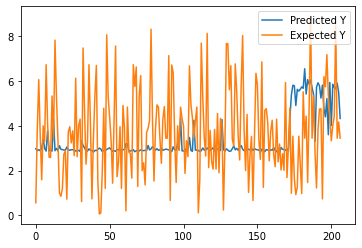

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# plot lines
plt.plot(predicted_y, label = "Predicted Y")
plt.plot(expected_y, label = "Expected Y")
# plt.plot(x, np.sin(x), label = "curve 1")
# plt.plot(x, np.cos(x), label = "curve 2")
plt.legend()
plt.show()